## Working with xcube on CDSE

[**xcube**](https://github.com/xcube-dev/xcube) is an open-source Python package and toolkit that has been developed to provide Earth observation (EO) data in an analysis-ready form to users. This is achieved by carefully converting EO data sources into self-contained data cubes (xarray.Datasets).

This notebook shows how to:
* Access Sentinel Hub with xcube on CDSE
* Effectively mask cube data
* Develop and run a Python function to compute a new variable that is automatically utilizing multiple threads
* Compute Time-series, means, anomalies of a variable
  
Please, refer to the [xcube documentation](https://xcube.readthedocs.io/en/latest/index.html) for further information.<br>
The xcube package is developed and maintained by [Brockmann Consult GmbH](https://www.brockmann-consult.de) and contributors.

***
### Prerequisites
#### Install the [xcube-sh](https://github.com/xcube-dev/xcube-sh/) data store plugin to allow accessing Setinel Hub on CDSE

Execute the following line in the Terminal to install the xcube store for Sentinel Hub into the respective environment: 

```
$ mamba install xcube-sh -n sentinelhub
```

This step could be omitted if xcube-sh is installed into the environment by default.

***

In [1]:
# xcube imports
from xcube.core.store import new_data_store
from xcube.core.compute import compute_cube
from xcube.core.maskset import MaskSet

# Various utilities
from sentinelhub import SHConfig

In [2]:
%matplotlib inline

### Credentials

Load client_id and client_secret from user's SHconfig to create a store instance. Note that the credentials they may also be inserted manually here. In a future release of xcube-sh, the endpoint urls may be integrated into a CDSE profile so that users do not have to provide them as parameters here. 

The creation of a user's SHconfig is also shown in a Jupyter Notebook under the path: ```samples/sentinelhub/introduction_to_SH_APIs.ipynb```

In [3]:
# Only run this cell if you have not created a configuration.

import getpass

config = SHConfig()
# config.sh_client_id = getpass.getpass("Enter your SentinelHub client id")
# config.sh_client_secret = getpass.getpass("Enter your SentinelHub client secret")
config.sh_base_url = "https://sh.dataspace.copernicus.eu"
config.sh_token_url = "https://identity.dataspace.copernicus.eu/auth/realms/CDSE/protocol/openid-connect/token"
# config.save("xcube")

***
### Create store instance and get an overview over the available products

To be able to access data records with xcube, so-called store instances must be created. These create connections either to the local file system, S3 buckets or various data portals (e.g. Sentinel Hub, CMEMS, CCI etc.). An overview of all stores and their properties can be found [here](https://xcube.readthedocs.io/en/latest/dataaccess.html#available-data-stores).

In [4]:
# config = SHConfig("xcube")

In [5]:
store = new_data_store(
    "sentinelhub",
    client_id=config.sh_client_id,
    client_secret=config.sh_client_secret,
    instance_url=config.sh_base_url,
    oauth2_url=config.sh_token_url.rsplit("/", maxsplit=1)[0],
)

The following datasets are available through the sentinelhub store:

In [6]:
store.list_data_ids()

['S2L1C', 'S3OLCI', 'S3SLSTR', 'S1GRD', 'S2L2A', 'S5PL2']

***
### Study area
For this demo, we are focussing on the small lake *Selenter See* near Kiel, Northern Germany (Baltic Sea):

In [7]:
x1 = 10.37  # degree
y1 = 54.28  # degree
x2 = 10.52  # degree
y2 = 54.33  # degree

bbox = x1, y1, x2, y2

Later in this NB we are going to compute some indexes from atmospherically corrected bands B04, B05, B06, B11 of Sentinel-2 (S2L2A).
Our time range covers two and a half months of the summer 2018: 2018-05-14 to 2018-07-31

The desired resolution is 20 meters per pixel.

In [8]:
spatial_res = 0.00018  # = 20.038 meters in degree

***
### Access data from sentinelhub store
Get an insight to the data product you are interested in. In the ``open_params_schema`` all parameters that can be used to specify the search for a product are listed. Including a list of variables, that are **required** for the search.

In [9]:
store.describe_data("S2L2A")

In [10]:
cube = store.open_data(
    "S2L2A",
    variable_names=["B04", "B05", "B06", "B11", "SCL", "CLD"],
    bbox=bbox,
    spatial_res=spatial_res,
    time_range=["2019-07-21", "2019-09-21"],
    time_period="4D",
    tile_size=[512, 512],
)
cube

<xarray.Dataset>
Dimensions:    (time: 16, lat: 278, lon: 1024, bnds: 2)
Coordinates:
  * lat        (lat) float64 54.33 54.33 54.33 54.33 ... 54.28 54.28 54.28 54.28
  * lon        (lon) float64 10.37 10.37 10.37 10.37 ... 10.55 10.55 10.55 10.55
  * time       (time) datetime64[ns] 2019-07-23 2019-07-27 ... 2019-09-21
    time_bnds  (time, bnds) datetime64[ns] dask.array<chunksize=(16, 2), meta=np.ndarray>
Dimensions without coordinates: bnds
Data variables:
    B04        (time, lat, lon) float32 dask.array<chunksize=(1, 278, 512), meta=np.ndarray>
    B05        (time, lat, lon) float32 dask.array<chunksize=(1, 278, 512), meta=np.ndarray>
    B06        (time, lat, lon) float32 dask.array<chunksize=(1, 278, 512), meta=np.ndarray>
    B11        (time, lat, lon) float32 dask.array<chunksize=(1, 278, 512), meta=np.ndarray>
    CLD        (time, lat, lon) uint8 dask.array<chunksize=(1, 278, 512), meta=np.ndarray>
    SCL        (time, lat, lon) uint8 dask.array<chunksize=(1, 278, 512), meta=np.ndarray>
Attributes: (12/13)
    Conventions:               CF-1.7
    title:                     S2L2A Data Cube Subset
    history:                   [{'program': 'xcube_sh.chunkstore.SentinelHubC...
    date_created:              2024-05-13T14:42:05.877516
    time_coverage_start:       2019-07-21T00:00:00+00:00
    time_coverage_end:         2019-09-23T00:00:00+00:00
    ...                        ...
    time_coverage_resolution:  P4DT0H0M0S
    geospatial_lon_min:        10.37
    geospatial_lat_min:        54.28
    geospatial_lon_max:        10.554319999999999
    geospatial_lat_max:        54.330040000000004
    processing_level:          L2A

***
### Masking
The band `SCL` provides *scene classification flags*. Because this "band" has CF-compliant flag encodings in its metadata attributes, we can interpret them correctly:

In [11]:
scene_classif = MaskSet(cube.SCL)
scene_classif

Flag name,Mask,Value
no_data,None,0
saturated_or_defective,None,1
dark_area_pixels,None,2
cloud_shadows,None,3
vegetation,None,4
bare_soils,None,5
water,None,6
clouds_low_probability_or_unclassified,None,7
clouds_medium_probability,None,8
clouds_high_probability,None,9


xcube mask sets also follow data cube structure:

In [12]:
scene_classif.cirrus

<xarray.DataArray 'cirrus' (time: 16, lat: 278, lon: 1024)>
dask.array<where, shape=(16, 278, 1024), dtype=uint8, chunksize=(1, 278, 512), chunktype=numpy.ndarray>
Coordinates:
  * lat      (lat) float64 54.33 54.33 54.33 54.33 ... 54.28 54.28 54.28 54.28
  * lon      (lon) float64 10.37 10.37 10.37 10.37 ... 10.55 10.55 10.55 10.55
  * time     (time) datetime64[ns] 2019-07-23 2019-07-27 ... 2019-09-21

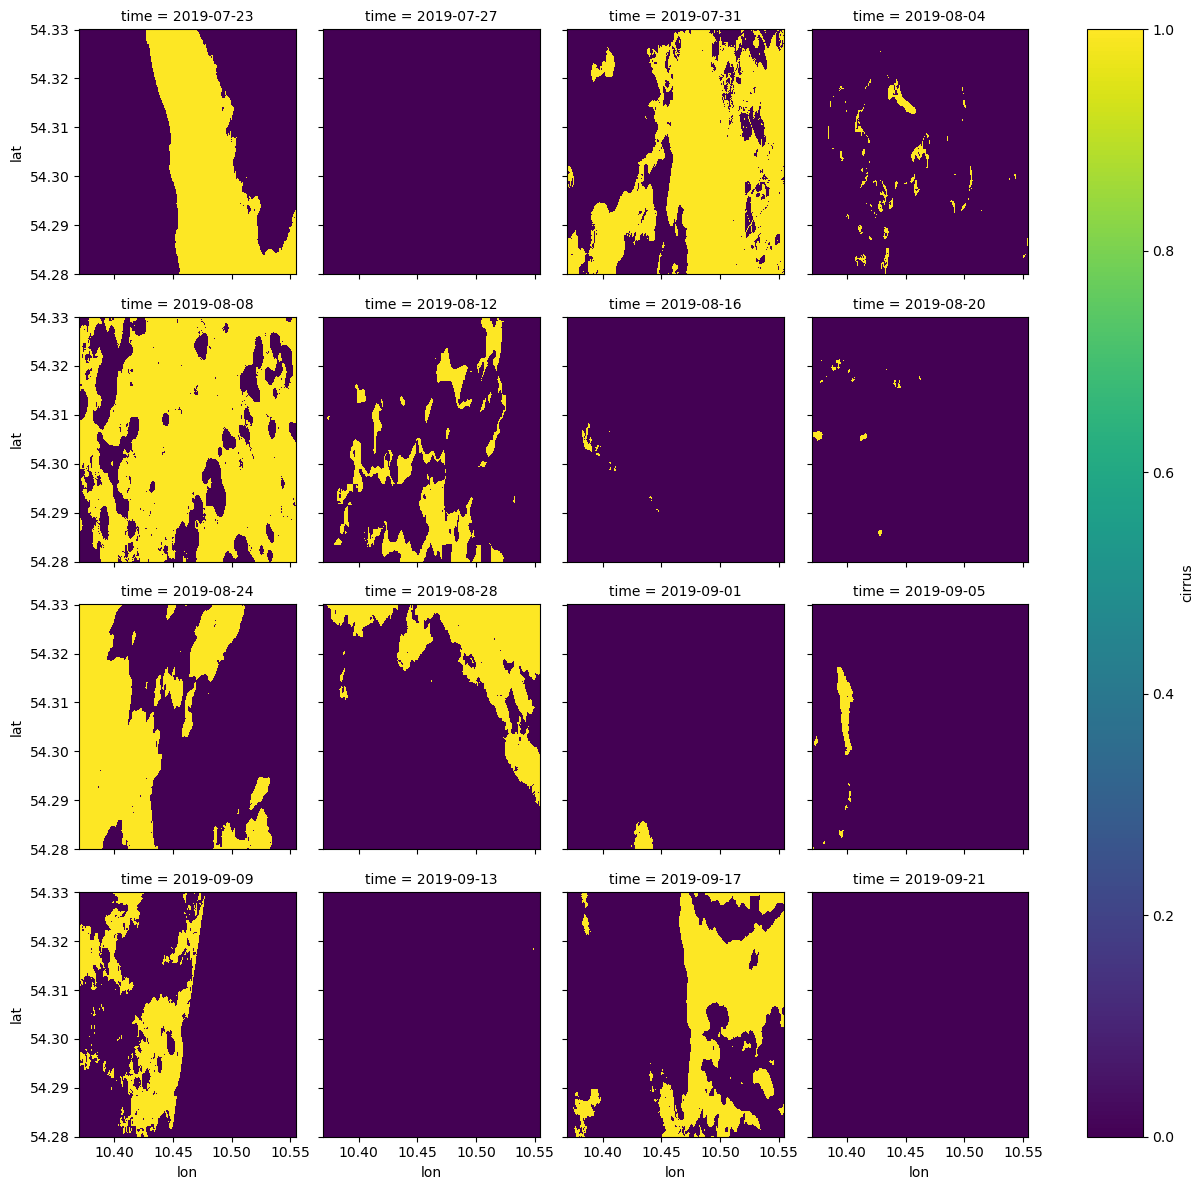

In [13]:
scene_classif.cirrus.plot.imshow(col="time", col_wrap=4, cmap="viridis")

We can use any of the SCL masks or combinations thereof to mask entire cubes. Here we create a "water cube":

In [14]:
water_cube = cube.where(scene_classif.water)
water_cube

<xarray.Dataset>
Dimensions:    (time: 16, lat: 278, lon: 1024, bnds: 2)
Coordinates:
  * lat        (lat) float64 54.33 54.33 54.33 54.33 ... 54.28 54.28 54.28 54.28
  * lon        (lon) float64 10.37 10.37 10.37 10.37 ... 10.55 10.55 10.55 10.55
  * time       (time) datetime64[ns] 2019-07-23 2019-07-27 ... 2019-09-21
    time_bnds  (time, bnds) datetime64[ns] dask.array<chunksize=(16, 2), meta=np.ndarray>
Dimensions without coordinates: bnds
Data variables:
    B04        (time, lat, lon) float32 dask.array<chunksize=(1, 278, 512), meta=np.ndarray>
    B05        (time, lat, lon) float32 dask.array<chunksize=(1, 278, 512), meta=np.ndarray>
    B06        (time, lat, lon) float32 dask.array<chunksize=(1, 278, 512), meta=np.ndarray>
    B11        (time, lat, lon) float32 dask.array<chunksize=(1, 278, 512), meta=np.ndarray>
    CLD        (time, lat, lon) float32 dask.array<chunksize=(1, 278, 512), meta=np.ndarray>
    SCL        (time, lat, lon) float32 dask.array<chunksize=(1, 278, 512), meta=np.ndarray>
Attributes: (12/13)
    Conventions:               CF-1.7
    title:                     S2L2A Data Cube Subset
    history:                   [{'program': 'xcube_sh.chunkstore.SentinelHubC...
    date_created:              2024-05-13T14:42:05.877516
    time_coverage_start:       2019-07-21T00:00:00+00:00
    time_coverage_end:         2019-09-23T00:00:00+00:00
    ...                        ...
    time_coverage_resolution:  P4DT0H0M0S
    geospatial_lon_min:        10.37
    geospatial_lat_min:        54.28
    geospatial_lon_max:        10.554319999999999
    geospatial_lat_max:        54.330040000000004
    processing_level:          L2A

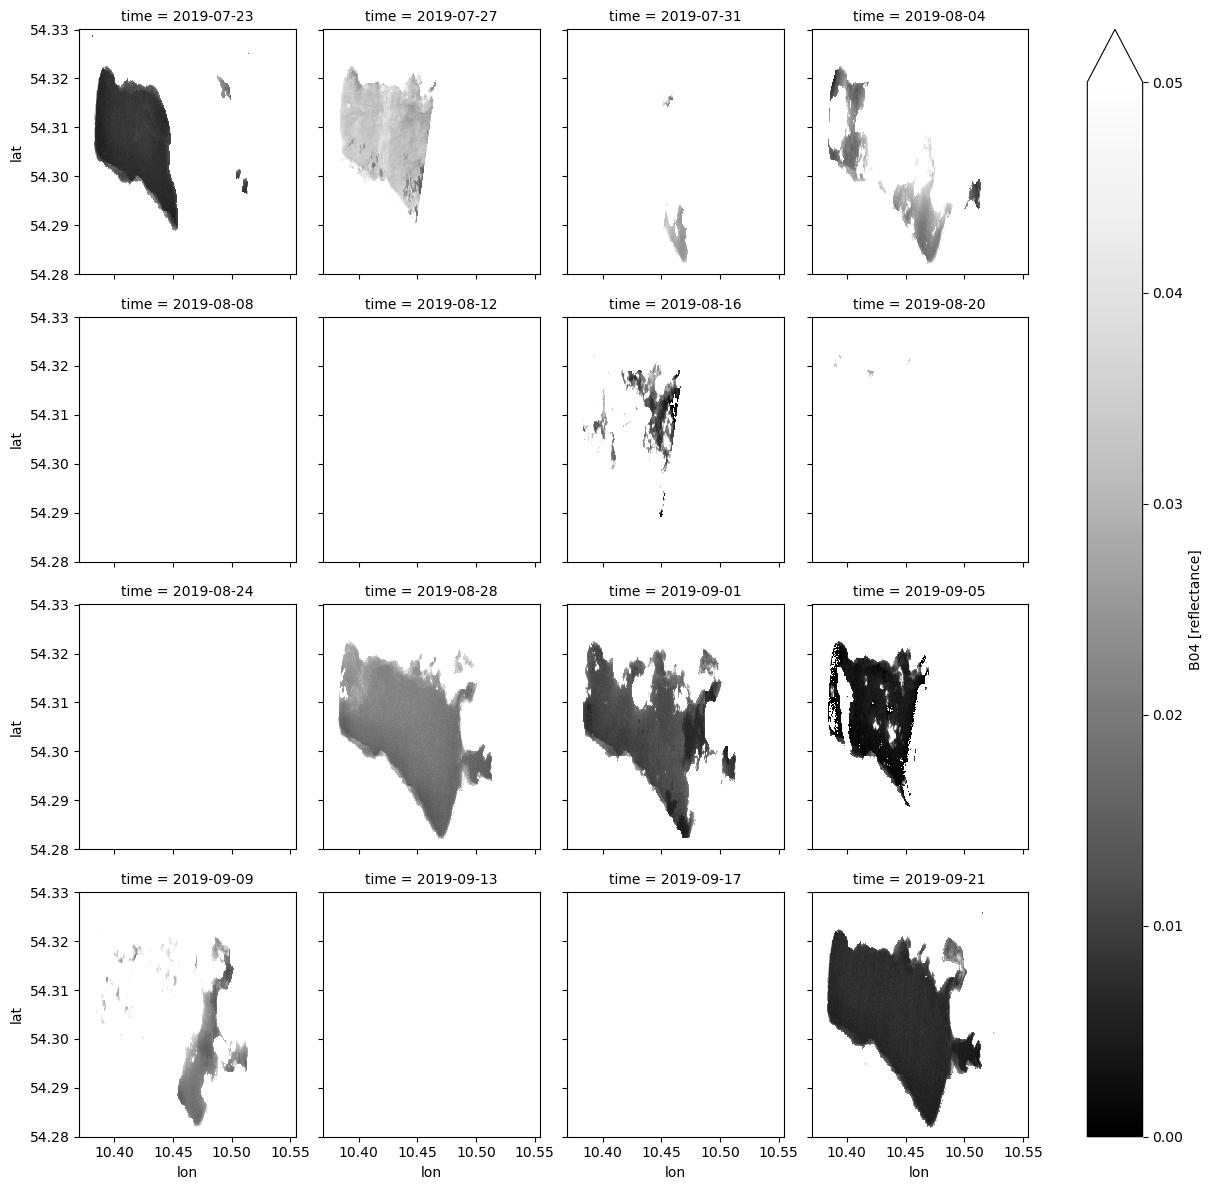

In [15]:
water_cube.B04.plot.imshow(col="time", col_wrap=4, vmin=0, vmax=0.05, cmap="Greys_r")

***
### Compute Index and generate a new cube
We now compute a Chlorophyll indicator called *Maximum Chlorophyll Index* from bands B04, B05, B06. Note, that it uses the wavelength for the bands as input parameters. 
The function is called for every *data chunk* in the cube and returns a chunk for the variable to be computed. Chunks are computed independently and in parallel.

In [16]:
def compute_mci(b_from, b_peek, b_to, input_params, dim_coords):
    # The first three arguments are chunks of the three input variables we define below.
    # You can name them as you like. They are pure 3D numpy arrays.

    # The 'input_params' argument is a standard parameter that we define in the call below.
    wlen_from = input_params["wlen_from"]
    wlen_peek = input_params["wlen_peek"]
    wlen_to = input_params["wlen_to"]

    # The 'dim_coords' argument is optional and provides the coordinate values for all dimension
    # of the current chunk. We don't use it here, but for many algorithms this is important
    # information (e.g. looking up aux data).
    lon, lat = (dim_coords[dim] for dim in ("lon", "lat"))
    # print('dim_coords from', lon[0], lat[0], 'to', lon[-1], lat[-1])

    # You can use any popular data packages such as numpy, scipy, dask here,
    # or we can use ML packages such as scikitlearn!
    # For simplity, we do some very simple array math here:

    f = (wlen_peek - wlen_from) / (wlen_to - wlen_from)
    mci = (b_peek - b_from) - f * (b_to - b_from)

    return mci

Prepare input parameters from band attributes:

In [17]:
input_params = dict(
    wlen_from=water_cube.B04.attrs["wavelength"],
    wlen_peek=water_cube.B05.attrs["wavelength"],
    wlen_to=water_cube.B06.attrs["wavelength"],
)
input_params

{'wlen_from': 664.75, 'wlen_peek': 703.95, 'wlen_to': 739.8}

In [18]:
mci_cube = compute_cube(
    compute_mci,
    water_cube,
    input_var_names=["B04", "B05", "B06"],
    input_params=input_params,
    output_var_name="mci",
)
mci_cube

/opt/conda/envs/sentinelhub/lib/python3.10/site-packages/xcube/core/compute.py:361: RuntimeWarning: Failed to open Zarr store with consolidated metadata, but successfully read with non-consolidated metadata. This is typically much slower for opening a dataset. To silence this warning, consider:
1. Consolidating metadata in this existing store with zarr.consolidate_metadata().
2. Explicitly setting consolidated=False, to avoid trying to read consolidate metadata, or
3. Explicitly setting consolidated=True, to raise an error in this case instead of falling back to try reading non-consolidated metadata.
  dataset = xr.open_zarr(store)


<xarray.Dataset>
Dimensions:  (lat: 278, lon: 1024, time: 16)
Coordinates:
  * lat      (lat) float64 54.33 54.33 54.33 54.33 ... 54.28 54.28 54.28 54.28
  * lon      (lon) float64 10.37 10.37 10.37 10.37 ... 10.55 10.55 10.55 10.55
  * time     (time) datetime64[ns] 2019-07-23 2019-07-27 ... 2019-09-21
Data variables:
    mci      (time, lat, lon) float64 dask.array<chunksize=(1, 278, 512), meta=np.ndarray>

In [19]:
mci_cube.mci.attrs["long_name"] = "Maximum Chlorophyll Index"
mci_cube.mci.attrs["units"] = "unitless"
mci_cube.mci

<xarray.DataArray 'mci' (time: 16, lat: 278, lon: 1024)>
dask.array<transpose, shape=(16, 278, 1024), dtype=float64, chunksize=(1, 278, 512), chunktype=numpy.ndarray>
Coordinates:
  * lat      (lat) float64 54.33 54.33 54.33 54.33 ... 54.28 54.28 54.28 54.28
  * lon      (lon) float64 10.37 10.37 10.37 10.37 ... 10.55 10.55 10.55 10.55
  * time     (time) datetime64[ns] 2019-07-23 2019-07-27 ... 2019-09-21
Attributes:
    long_name:  Maximum Chlorophyll Index
    units:      unitless

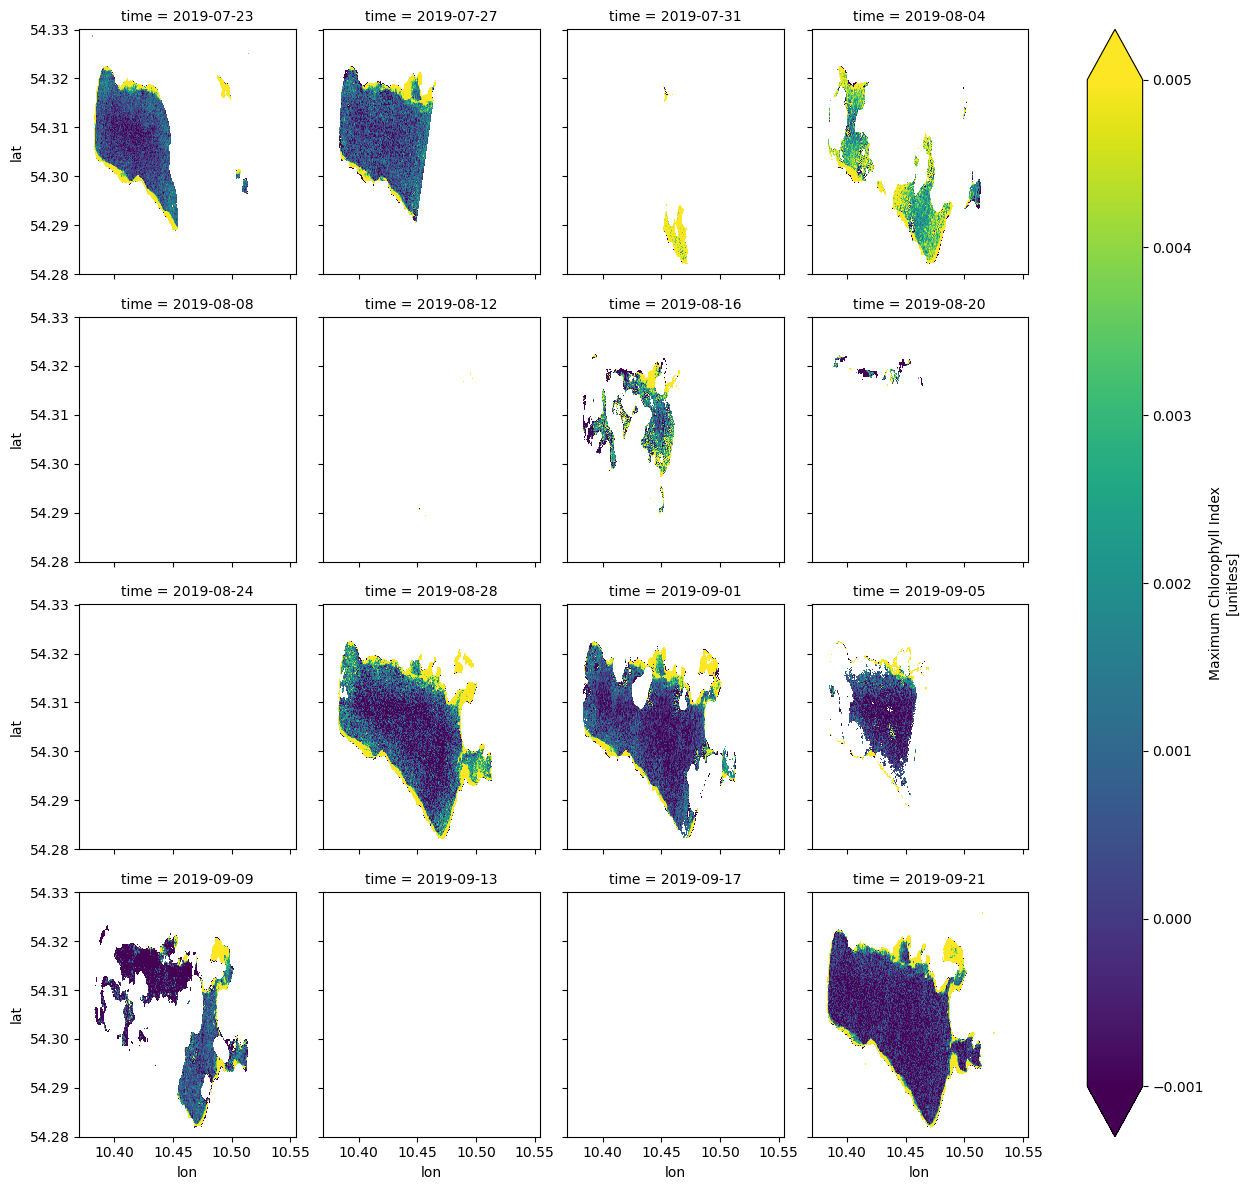

In [20]:
mci_cube.mci.plot.imshow(
    col="time", col_wrap=4, vmin=-0.001, vmax=0.005, cmap="viridis"
)

***
### Time Series

The data cube consists of 16 time steps, each representing a four-day period (see Access Data).
When plotting time series, gaps may appear between some points/time intervals. This is due to missing values within those intervals, often caused by factors such as cloud cover, which has been masked above (see Masking).
Alternatively, scatter plots could be used to avoid these gaps.

Time series at a given point:

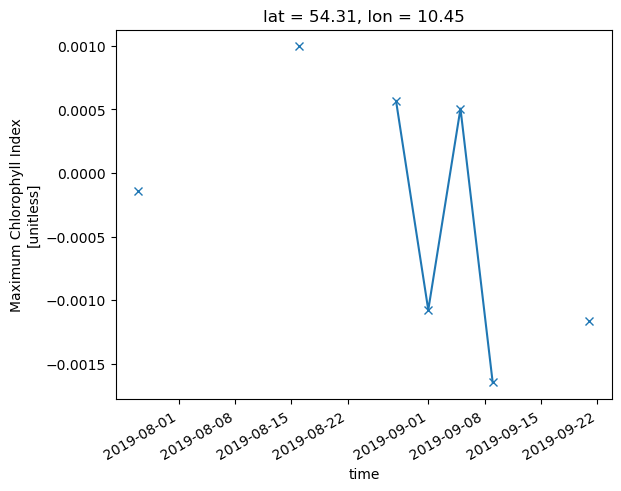

In [21]:
mci_cube.mci.sel(lat=54.31, lon=10.45, method="nearest").plot.line(marker="x")

Time series of the means of each time step:

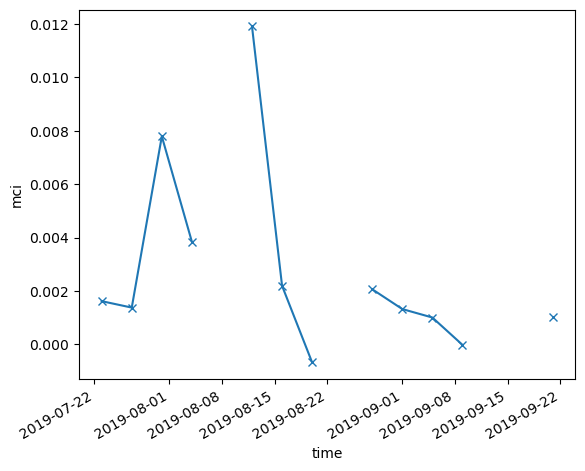

In [22]:
mci_cube.mci.mean(dim=("lat", "lon"), skipna=True).plot.line(marker="x")

Mean of all time steps:

In [23]:
mci_mean = mci_cube.mci.mean(dim="time")

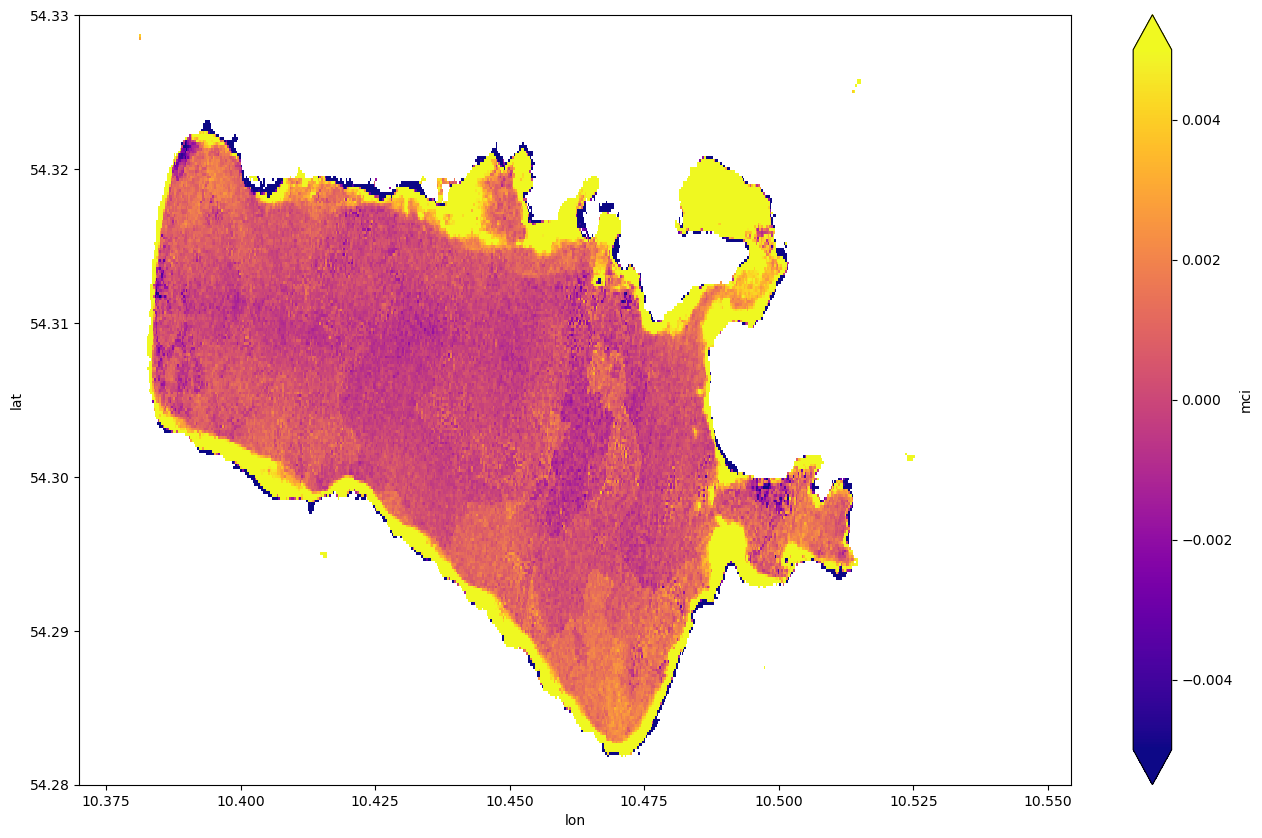

In [24]:
mci_mean.plot.imshow(vmin=-0.005, vmax=0.005, cmap="plasma", figsize=(16, 10))

Anomaly w.r.t. to the mean for each time step:

In [25]:
mci_anomaly = mci_cube.mci - mci_mean

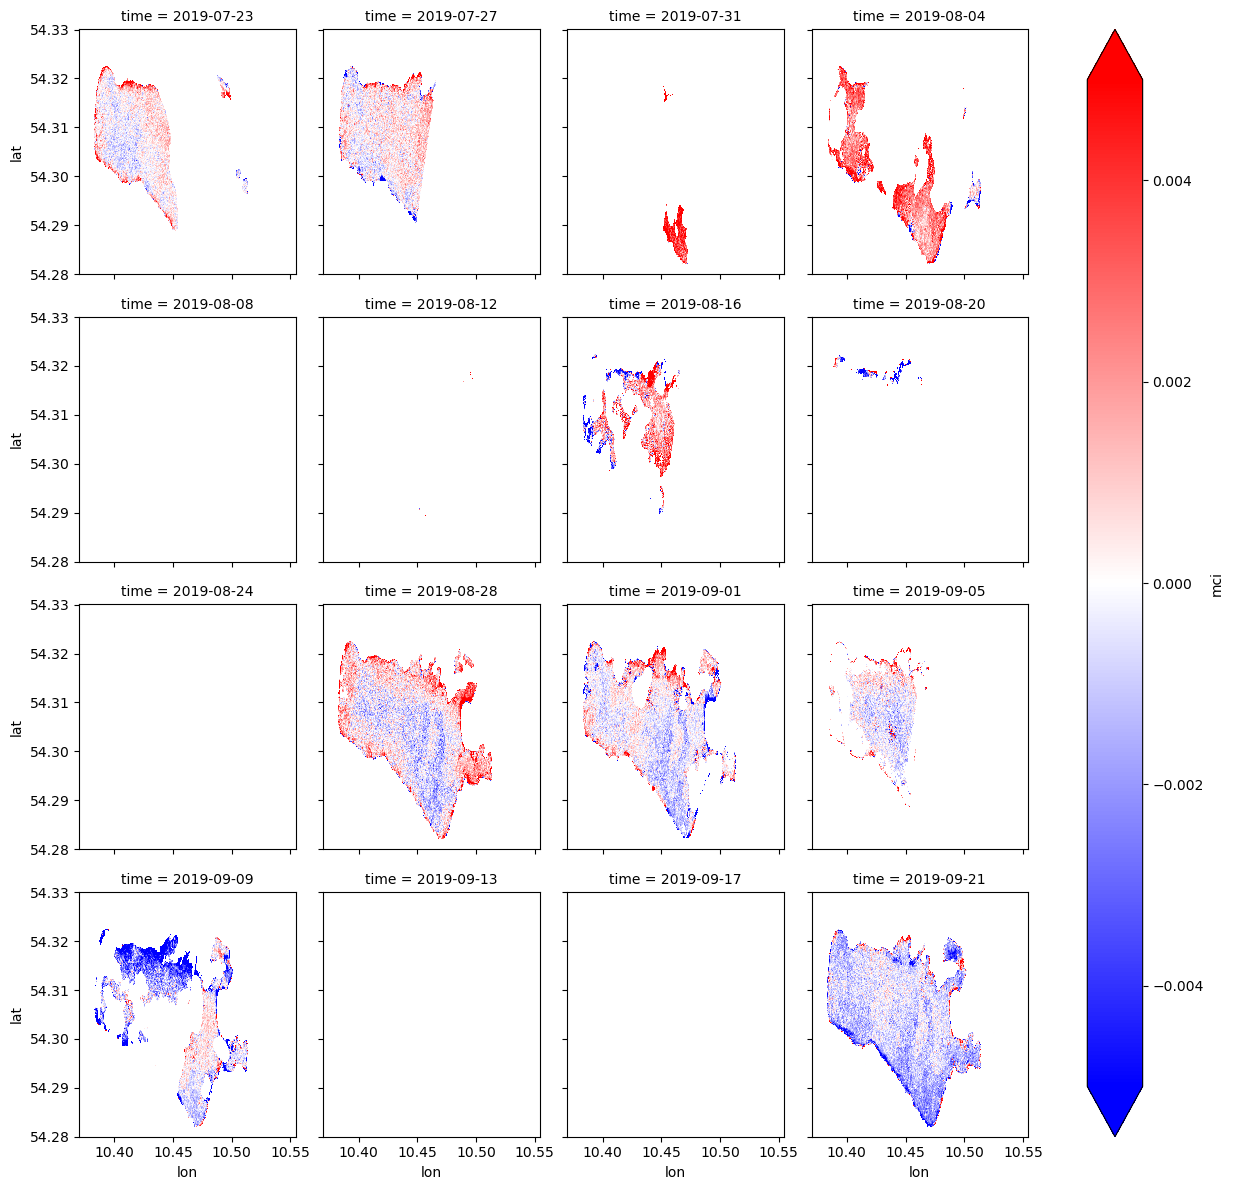

In [26]:
mci_anomaly.plot.imshow(col="time", col_wrap=4, vmin=-0.005, vmax=0.005, cmap="bwr")

***
### Export result cube
Save the cube locally:

In [27]:
import shutil

shutil.rmtree("mci_cube.zarr", ignore_errors=True)  # Delete, if already exists

In [28]:
mci_cube.to_zarr("mci_cube.zarr")